# Compare and analyze the used models
Especially why they don't work.

In [1]:
import os
import re
from itertools import islice

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm
import keras

import vixstructure.data as data

Using TensorFlow backend.


## Naive stacking of fully-connected layers

### Number of hidden layers

The following plot compares the number of hidden layers (increasing from 1 to 10) and its influence on the resulting loss and accuracy (TODO: How is accuracy calculated?). The validation looks rather strange and its recommended to first check the implementation of the respective calculations.

In [2]:
relpath = "logs/naive-fully-connected"
dirtree = [dirtree for dirtree in os.walk("logs") if dirtree[0] == relpath][0]
filenames = [filename for filename in dirtree[2] if filename[-4:] == ".log"]
# Sort the files by number of hidden layers.
filenames.sort(key=lambda x: int(re.findall(r"""(?<=training_)[0-9]+(?=_)""", x)[0]))
csvdata = tuple(pd.read_csv(os.path.join(dirtree[0], filename), header=0, index_col=0, dtype=np.float32)
             for filename in filenames)

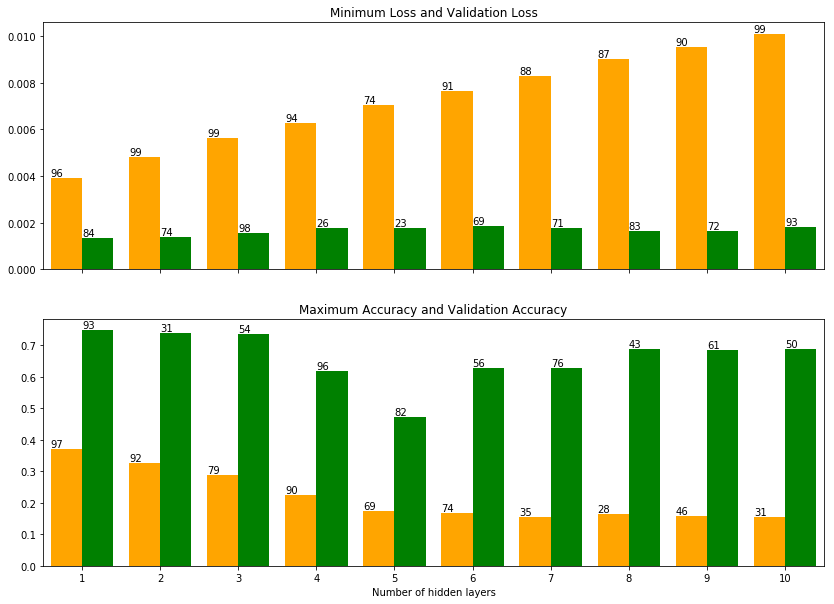

In [3]:
f, axs = plt.subplots(2, sharex=True)
f.set_size_inches(14, 10)
for idx, sample in enumerate(csvdata):
    rect = axs[0].bar(idx + 0.8, sample["loss"].min(), width=0.4, color="orange")
    axs[0].text(rect[0].get_x(), rect[0].get_height(), int(sample["loss"].argmin()) + 1, ha="left", va="bottom")
    rect = axs[0].bar(idx + 1.2, sample["val_loss"].min(), width=0.4, color="green")
    axs[0].text(rect[0].get_x(), rect[0].get_height(), int(sample["val_loss"].argmin()) + 1, ha="left", va="bottom")
axs[0].set_title("Minimum Loss and Validation Loss")
for idx, sample in enumerate(csvdata):
    rect = axs[1].bar(idx + 0.8, sample["acc"].max(), width=0.4, color="orange")
    axs[1].text(rect[0].get_x(), rect[0].get_height(), int(sample["acc"].argmax()) + 1, ha="left", va="bottom")
    rect = axs[1].bar(idx + 1.2, sample["val_acc"].max(), width=0.4, color="green")
    axs[1].text(rect[0].get_x(), rect[0].get_height(), int(sample["val_acc"].argmax()) + 1, ha="left", va="bottom")
axs[1].xaxis.set_ticks(np.arange(1, 11))
axs[1].set_title("Maximum Accuracy and Validation Accuracy")
axs[1].set_xlabel("Number of hidden layers")
axs[1].set_xlim(0.5,10.5)
plt.show()

The numbers above the bars represent the epoch number with the best results. The training was running for 100 epochs in total.

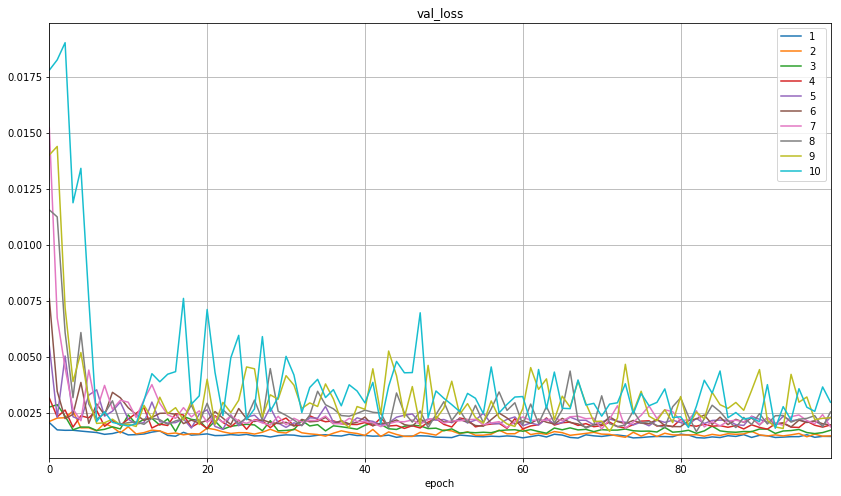

In [4]:
index_title = "val_loss"
for idx, d in enumerate(csvdata):
    d[index_title].plot(figsize=(14,8), label=idx + 1)
plt.title(index_title)
plt.legend()
plt.grid()
plt.show()

### Visualize predictions

Use the model with two hidden layers because the performance seems more stable.

In [5]:
model2 = keras.models.load_model("models/naive-fully-connected/naive_2_7_7.hdf5")
model2.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input (InputLayer)           (None, 7, 9)              0         
_________________________________________________________________
flatten_2 (Flatten)          (None, 63)                0         
_________________________________________________________________
dense_2 (Dense)              (None, 63)                4032      
_________________________________________________________________
dropout_2 (Dropout)          (None, 63)                0         
_________________________________________________________________
dense_3 (Dense)              (None, 63)                4032      
_________________________________________________________________
dropout_3 (Dropout)          (None, 63)                0         
_________________________________________________________________
output (Dense)               (None, 8)                 512       
Total para

In [37]:
def make_array(array_like) -> np.ndarray:
    return np.squeeze(np.array(array_like))
datalen, datagen = data.get_data_generators(7, 7, None)
datalist = list(islice(datagen, datalen))
inputdata, targetdata = zip(*datalist)
preds = data.denormalize(make_array([model2.predict(databatch) for databatch in inputdata]))
# Get non-normalized original data for targets
originaldata = data.get_data()
dates = originaldata.index.date
vix_data = originaldata.iloc[:,0].values
targetdata = originaldata.iloc[7:-7,1:].interpolate(axis=1).fillna(method="bfill", axis=1).values
assert len(preds) == datalen
assert len(inputdata) == datalen
assert len(targetdata) == datalen

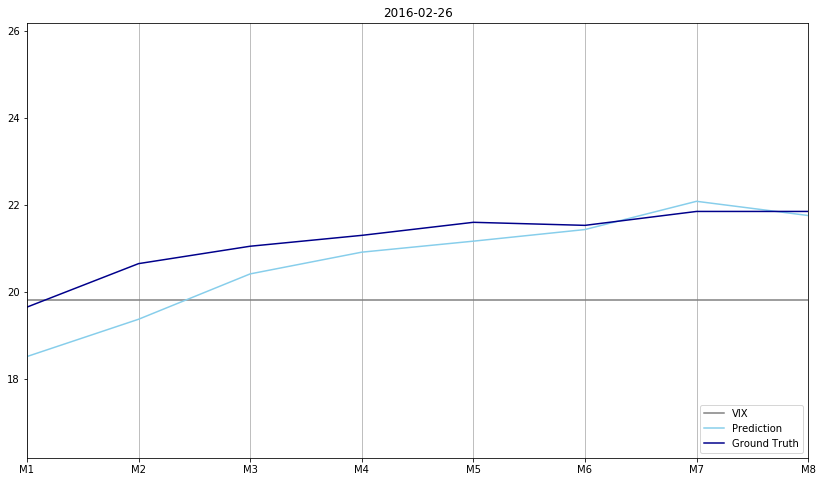

In [77]:
def plot_date(index: int, save: bool=False):
    x = np.arange(8)
    xlabels = tuple(f"M{i}" for i in range(1,9))
    plt.figure(figsize=(14,8))
    global vix_data
    plt.axhline(vix_data[index], color="gray")
    global preds
    plt.plot(x, np.squeeze(preds[index]), color="skyblue")
    global targetdata
    plt.plot(x, np.squeeze(targetdata[index]), color="darkblue")
    plt.xticks(x, xlabels)
    plt.xlim(0, 7)
    mean = targetdata[index].mean()
    plt.ylim(mean - 5, mean + 5)
    plt.grid(axis="x")
    global dates
    plt.title(dates[index])
    plt.legend(["VIX", "Prediction", "Ground Truth"], loc="lower right")
    if not save:
        plt.show()
    else:
        plt.savefig("prediction_term_structure_figures/{:04d}.png".format(index))
        plt.close()
plot_date(3000)

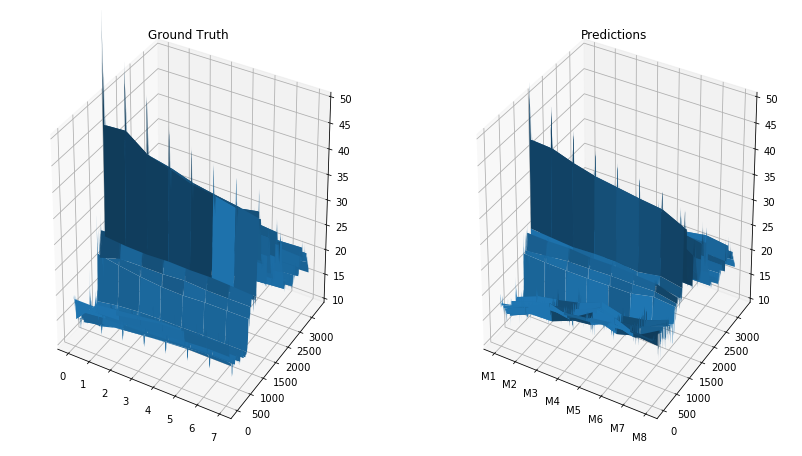

In [8]:
fig = plt.figure(figsize=(14, 8))
X, Y = np.meshgrid(np.arange(8), np.arange(3291))
ax0 = fig.add_subplot(121, projection='3d')
ax0.plot_surface(X, Y, targetdata)
ax0.set_zlim(10,50)
ax0.set_title("Ground Truth")
ax1 = fig.add_subplot(122, projection='3d')
ax1.plot_surface(X, Y, preds)
ax1.set_zlim(10,50)
ax1.set_title("Predictions")
plt.xticks(x, xlabels)
plt.show()